In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, SGD

In [3]:
def load_dataset(path, batch_size, img_size):
    train_dir = os.path.join(path, 'train')
    validation_dir = os.path.join(path, 'val')

    train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=img_size,
                                                            label_mode='categorical')
    class_names = train_dataset.class_names
    validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=batch_size,
                                                                 image_size=img_size,
                                                                 label_mode='categorical')
    val_batches = tf.data.experimental.cardinality(validation_dataset)
    test_dataset = validation_dataset.take(val_batches // 5)
    validation_dataset = validation_dataset.skip(val_batches // 5)

    AUTOTUNE = tf.data.AUTOTUNE

    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

    return train_dataset, validation_dataset, test_dataset, class_names



In [4]:
def plot_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [5]:
def create_model(img_size, num_classes, base_model_trainable=False, activation='softmax', data_augmentation=None):
    img_shape = img_size+(3,)

    if data_augmentation is None:
        data_augmentation = tf.keras.Sequential([
          tf.keras.layers.RandomFlip('horizontal'),
          tf.keras.layers.RandomRotation(0.2),
        ])

    preprocess_input = tf.keras.applications.inception_v3.preprocess_input

    base_model = tf.keras.applications.InceptionV3(input_shape=img_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = base_model_trainable

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    prediction_layer = tf.keras.layers.Dense(num_classes, activation=activation)

    inputs = tf.keras.Input(shape=img_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return base_model, model

In [6]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger

csv_logger = CSVLogger("model_history_log.csv", append=True)



# Define the filepath for saving the checkpoints
checkpoint_filepath = '/content/drive/MyDrive/customized_imagenet/checkpoints5/epochs:{epoch:03d}.hdf5'
checkpoint_filepath2 = '/content/drive/MyDrive/customized_imagenet/checkpoints6/epochs:{epoch:03d}.keras'

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_freq="epoch",
    save_weights_only=False,  # Save the entire model
    monitor='val_accuracy',  # Monitor validation accuracy for saving the best model
    mode='max',  # Maximize the monitored quantity
    verbose=1  # Show messages about checkpoint saving
)

checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_freq="epoch",
    save_weights_only=False,  # Save the entire model
    monitor='val_accuracy',  # Monitor validation accuracy for saving the best model
    mode='max',  # Maximize the monitored quantity
    verbose=1  # Show messages about checkpoint saving
)

callbacks_list = [checkpoint_callback,checkpoint_callback2, csv_logger]

In [7]:
PATH = "/content/drive/MyDrive/customized_imagenet"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 20

In [8]:
def train_model(model, train, validation, test, epochs=EPOCHS):
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=RMSprop(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])
    history = model.fit(train, epochs=epochs, validation_data=validation, callbacks=callbacks_list)
    _, test_accuracy = model.evaluate(test)
    return history, test_accuracy

In [9]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Categorical Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

Found 34681 files belonging to 319 classes.
Found 3923 files belonging to 319 classes.


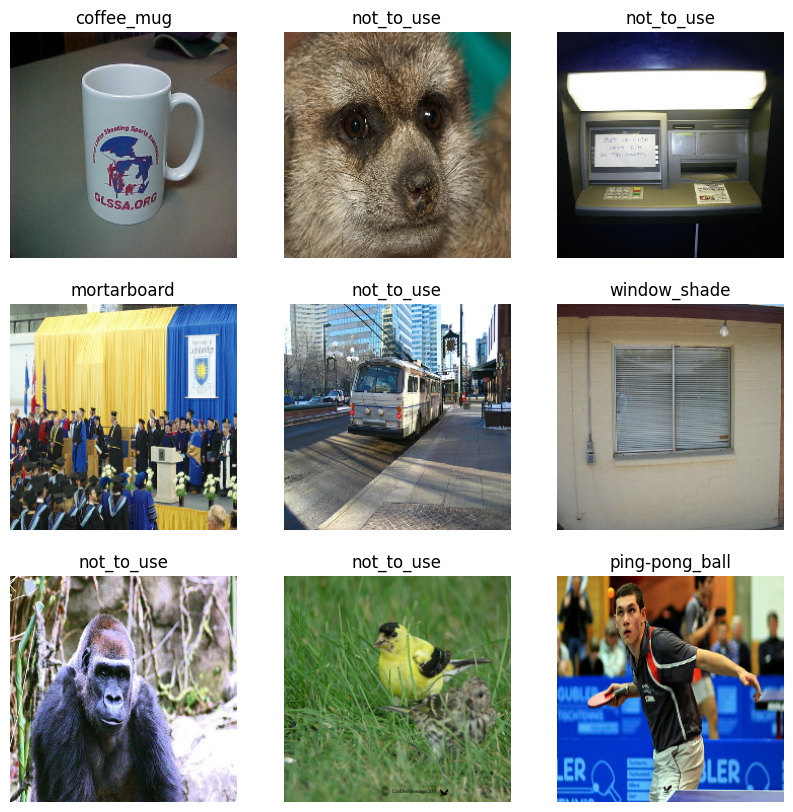

In [10]:
train, validation, test, class_names = load_dataset(PATH, BATCH_SIZE, IMG_SIZE)
num_classes = len(class_names)
plot_dataset(train, class_names)

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: saving model to /content/drive/MyDrive/customized_imagenet/checkpoints6/epochs:001.keras
1084/1084 [==============================] - 1441s 1s/step - loss: 1.5870 - accuracy: 0.7170 - val_loss: 0.9947 - val_accuracy: 0.7994
Epoch 2/20
1082/1084 [============================>.] - ETA: 0s - loss: 1.1204 - accuracy: 0.7711
Epoch 2: saving model to /content/drive/MyDrive/customized_imagenet/checkpoints5/epochs:002.hdf5

Epoch 2: saving model to /content/drive/MyDrive/customized_imagenet/checkpoints6/epochs:002.keras
1084/1084 [==============================] - 69s 63ms/step - loss: 1.1198 - accuracy: 0.7712 - val_loss: 1.0448 - val_accuracy: 0.8032
Epoch 3/20
1082/1084 [============================>.] - ETA: 0s - loss: 1.0404 - accuracy: 0.7855
Epoch 3: saving model to /content/drive/MyDrive/customized_imagenet/checkpoints5/epochs:003.hdf5

Epoch 3: saving model to /content/drive/MyDrive/customized_imagenet/checkpoints6/epochs:003.keras
1084/1084 [==============================] 

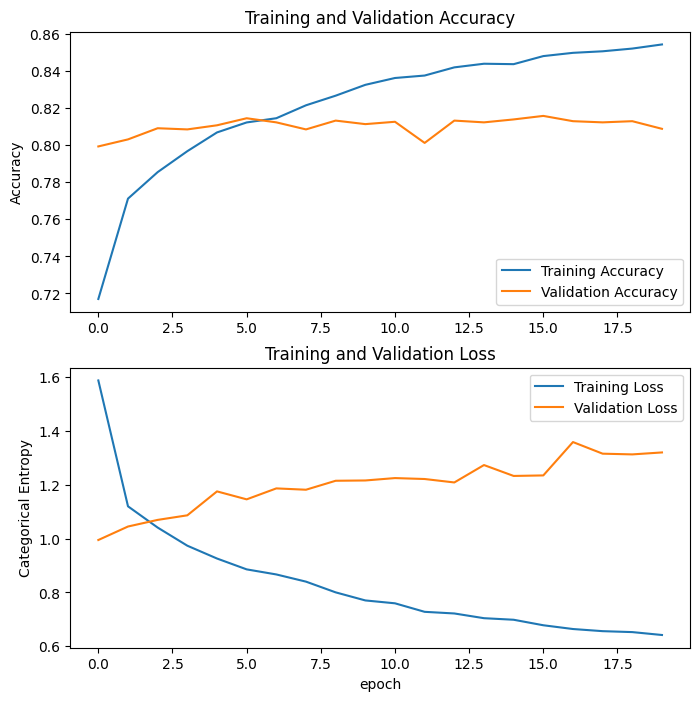

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.Rescaling(1./255)
])
base_model, model = create_model(IMG_SIZE, num_classes)
#base_model.trainable = True

# from keras.models import load_model

# load_checkpoint_file = '/content/drive/MyDrive/customized_imagenet/checkpoints2/epochs:010.hdf5'
# model = load_model(load_checkpoint_file)

model.summary()
history, ta = train_model(model, train, validation, test)
print(f"Test accuracy: {ta}")
plot_results(history)

In [12]:
model.save('/content/drive/MyDrive/customized_imagenet/history/my_final_model4.hdf5')

model.save('/content/drive/MyDrive/customized_imagenet/history/my_final_model5.keras')

In [15]:
from keras.models import load_model
model = tf.keras.models.load_model('/content/drive/MyDrive/customized_imagenet/history/my_final_model4.hdf5')
model2 = tf.keras.models.load_model('/content/drive/MyDrive/customized_imagenet/history/my_final_model5.keras')

In [30]:
imagess= ['/content/drive/MyDrive/customized_imagenet/Newtest/ILSVRC2012_test_00000005.JPEG',
          '/content/drive/MyDrive/customized_imagenet/Newtest/ILSVRC2012_test_00000017.JPEG',
          '/content/drive/MyDrive/customized_imagenet/Newtest/ILSVRC2012_test_00000044.JPEG',
          '/content/drive/MyDrive/customized_imagenet/Newtest/IMG_20240505_235234.jpg',
          '/content/drive/MyDrive/customized_imagenet/Newtest/IMG_20240505_235237.jpg',
          '/content/drive/MyDrive/customized_imagenet/Newtest/IMG_20240505_235240.jpg',
          '/content/drive/MyDrive/customized_imagenet/Newtest/IMG_20240505_235244.jpg',
          '/content/drive/MyDrive/customized_imagenet/Newtest/IMG_20240505_235249.jpg',
          '/content/drive/MyDrive/customized_imagenet/Newtest/IMG_20240505_235259.jpg',
          '/content/drive/MyDrive/customized_imagenet/Newtest/WhatsApp Image 2024-05-10 at 15.37.59_6cc1686a.jpg',
          '/content/drive/MyDrive/customized_imagenet/Newtest/photo_2024-05-10_14-59-03.jpg',
          '/content/drive/MyDrive/customized_imagenet/Newtest/photo_2024-05-10_14-59-17.jpg',
          '/content/drive/MyDrive/customized_imagenet/Newtest/photo_2024-05-10_14-59-31.jpg',
          '/content/drive/MyDrive/customized_imagenet/Newtest/photo_2024-05-10_14-59-46.jpg']

In [32]:
import numpy as np
from tensorflow.keras.preprocessing import image as image_utils
from PIL import Image
from keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img = Image.open(imagess[12])
img = img.resize((224, 224))  # Resize to match the input shape of your model
img_array = image_utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)  # Apply necessary preprocessing (e.g., mean subtraction)

prediction = model.predict(img_array)
prediction2 = model2.predict(img_array)

print(class_names[np.argmax(prediction)])
print(class_names[np.argmax(prediction2)])

1/1 [==============================] - 0s 26ms/step
not_to_use
not_to_use
